# 🥤 Coca-Cola Stock - Live and Updated

This notebook includes:

- 📈 Technical Indicator Calculation: MA, RSI, MACD, BBANDS
- 🤖 Random Forest Regressor to predict next-day `Close` price
- 🧠 Random Forest Classifier to predict Up/Down movement
- 📊 Evaluation using MSE, RMSE, MAE
- 📡 Live prediction using `yfinance`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
import ta

In [2]:
df = pd.read_csv('Coca-Cola_stock_history.csv', parse_dates=['Date'])
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True).dt.tz_convert(None)
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

In [3]:
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Volatility'] = df['Close'].rolling(window=20).std()
df['Daily Return'] = df['Close'].pct_change()

df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
macd = ta.trend.MACD(close=df['Close'])
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()
bb = ta.volatility.BollingerBands(close=df['Close'])
df['BB_High'] = bb.bollinger_hband()
df['BB_Low'] = bb.bollinger_lband()

df.dropna(inplace=True)

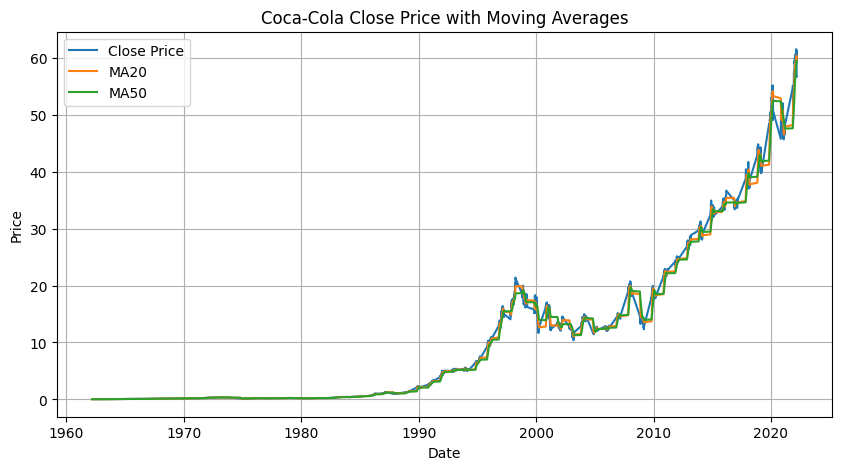

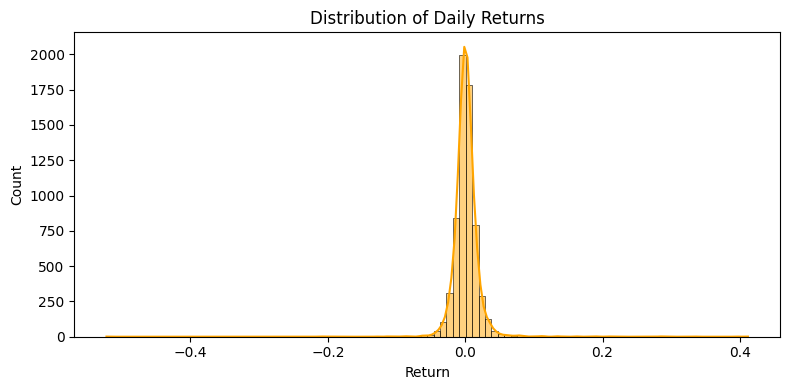

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['MA20'], label='MA20')
plt.plot(df['Date'], df['MA50'], label='MA50')
plt.title("Coca-Cola Close Price with Moving Averages")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(8, 4))
sns.histplot(df['Daily Return'], bins=100, kde=True, color='orange')
plt.title("Distribution of Daily Returns")
plt.xlabel("Return"); plt.tight_layout(); plt.show()

In [5]:
features = ['Open', 'High', 'Low', 'Volume', 'MA20', 'MA50', 'Volatility',
            'Daily Return', 'RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low']

X = df[features]
y = df['Close'].shift(-1)

df = df.iloc[:-1]
X = X.iloc[:-1]
y = y.iloc[:-1]

split = int(0.8 * len(df))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

MSE: 327.3337, RMSE: 18.0924, MAE: 13.8219


In [6]:
df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.dropna(inplace=True)

X_class = df[features]
y_class = df['Target']

split = int(0.8 * len(df))
Xc_train, Xc_test = X_class[:split], X_class[split:]
yc_train, yc_test = y_class[:split], y_class[split:]

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(Xc_train, yc_train)
yc_pred = clf.predict(Xc_test)

print(classification_report(yc_test, yc_pred))
print("Accuracy:", accuracy_score(yc_test, yc_pred))

              precision    recall  f1-score   support

           0       0.47      0.93      0.62       604
           1       0.50      0.06      0.11       681

    accuracy                           0.47      1285
   macro avg       0.48      0.50      0.37      1285
weighted avg       0.48      0.47      0.35      1285

Accuracy: 0.47003891050583657


In [7]:
live_df = yf.download('KO', period='3mo', interval='1d')
live_df.dropna(inplace=True)
live_df['MA20'] = live_df['Close'].rolling(window=20).mean()
live_df['MA50'] = live_df['Close'].rolling(window=50).mean()
live_df['Volatility'] = live_df['Close'].rolling(window=20).std()
live_df['Daily Return'] = live_df['Close'].pct_change()
close_series = live_df['Close'].squeeze()

try:
    live_df['RSI'] = ta.momentum.RSIIndicator(close=close_series, window=14).rsi()
except ValueError:
    live_df['RSI'] = ta.momentum.RSIIndicator(close=close_series.values, window=14).rsi()

try:
    macd_live = ta.trend.MACD(close=close_series)
except ValueError:
    macd_live = ta.trend.MACD(close=close_series.values)
    
live_df['MACD'] = macd_live.macd()
live_df['MACD_Signal'] = macd_live.macd_signal()

try:
    bb_live = ta.volatility.BollingerBands(close=close_series)
except ValueError:
    bb_live = ta.volatility.BollingerBands(close=close_series.values)

live_df['BB_High'] = bb_live.bollinger_hband()
live_df['BB_Low'] = bb_live.bollinger_lband()
live_df.dropna(inplace=True)
latest = live_df.iloc[-1][features].values.reshape(1, -1)
live_pred = clf.predict(latest)[0]
print("📈 Prediction:", "UP" if live_pred == 1 else "DOWN")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

📈 Prediction: DOWN



d:\Unified_Mentor\Project_1\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
